## Импорты

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm_notebook, trange, tqdm
import pickle
import numpy as np
from IPython.display import clear_output
import time
import string

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [0]:
device

device(type='cuda', index=0)

In [0]:
# !pip install telepyth -q

# from telepyth import TelepythClient

# tp = TelepythClient("14890519403566776828")

# Предобработка

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_path = '/content/drive/My Drive/vkr'
# base_path = '.'

- брать код из обычных репозиториев, а разбивку — из нормализованных
- сначала делаем выборку максимально без изворотов:
    - каждый файл нарезаем на части по n символов в каждом, если в последнем куске не n — выбрасываем
    - сохраняем выборку в файл pickle, пример: `[["import pickl",1], ...]` (потому что дальше идет "е", вероятно)
- преобразовать в удобный для модели формат:
    - вместо строк — массив чисел, где каждое число биективно соответствует символу
    
- модель учится предсказывать n+1 символ, если он eng letter, то это 1, иначе 0

In [0]:
# class PreprocessDataset():
#     def __init__(
#         self,
#         n,
#         path_to_filenames,
#         path_to_repo,
#         objects_limit,
#         check_if_english=True
#     ):
#         self.n = n
#         self.total_count = 0
#         self.pos_count = 0
#         with open(path_to_filenames, 'r') as f:
#             self.filenames = f.read().split('\n')
#         self.path_to_repo = path_to_repo
#         self.dataset_dictionary = set()
#         self.objects_limit = objects_limit
#         self.check_if_english = check_if_english
#         self.allowed_letters = set(string.printable)

#     def update_dataset_dictionary(self, code):
#         self.dataset_dictionary.update(set(code))
        
#     def is_english(self, code):
#         for char in code:
#             if char not in self.allowed_letters:
#                 return False
#         return True

#     def process_code(self, code):
#         self.update_dataset_dictionary(code)
#         chunks, chunk_size = len(code), self.n
#         slices = [code[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
#         self.total_count += len(slices) - 1
#         targets = []
#         for i in range(len(slices) - 1):
#             if slices[i+1][0].isalpha():
#                 self.pos_count += 1
#                 targets.append(True)
#             else:
#                 targets.append(False)
#         slices = slices[:-1]
#         objects_from_code = list(zip(slices, targets))
#         return objects_from_code
        
#     def make_dataset(self):
#         fidx = 0
#         pbar = tqdm(total=self.objects_limit)
#         objects_from_code = []
#         while self.total_count < self.objects_limit:
#             with open(
#                 self.path_to_repo + self.filenames[fidx],
#                 'r'
#             ) as code_file:
#                 code = code_file.read()
#             fidx += 1
#             if self.check_if_english and not self.is_english(code):
#                 continue
#             objects_from_code += self.process_code(code)
#             pbar.update(self.total_count)
#         pbar.close()
# #         print(objects_from_code)

#         print('Number of positives samples is {} out of {} ({:.2f}%)'.format(
#             self.pos_count,
#             self.total_count,
#             100. * self.pos_count / self.total_count
#         ))
        
# #         print(len(self.dataset_dictionary), self.dataset_dictionary)
        
#         return objects_from_code


In [0]:
# prep_dataset = PreprocessDataset(
#     20,
#     base_path + '/pycodesuggest_py_repos_normalised/train_files.txt',
#     base_path + '/pycodesuggest_py_repos_normalised/',
#     objects_limit=5000000
# )
# objects_from_code = prep_dataset.make_dataset()


31566657837it [00:25, 1221527424.58it/s]                      

Number of positives samples is 2565009 out of 5000289 (51.30%)


In [0]:
# objects_from_code[:10]

[('import json\nimport o', True),
 ('s\nimport sys\ntry:\n  ', False),
 ('  import urllib.requ', True),
 ('est as urllib2\nexcep', True),
 ('t ImportError:\n    i', True),
 ('mport urllib2\nvar266', False),
 ("5 = 'https://tldr-bo", True),
 ('t.starbeamrainbowlab', True),
 ("s.com/'\n\n\ndef functi", True),
 ('on2743(arg1358, arg5', False)]

In [0]:
prep_dataset.dataset_dictionary

{'\t',
 '\n',
 '\x0c',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~'}

In [0]:
with open(base_path + '/objects_from_code.pickle', 'rb') as f:
    objects_from_code = pickle.load(f)


In [0]:
tokens = set(['\t', '\n', '\x0c', ' ', '!', '"', '#', '$', '%', '&', "'",
             '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3',
             '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?',
             '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
             'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{',
             '|', '}', '~']
         )
tok2id = dict(zip(tokens, range(len(tokens))))
id2tok = dict(list(map(lambda x: x[::-1], list(tok2id.items()))))

In [0]:
tok2id

{'\t': 82,
 '\n': 9,
 '\x0c': 34,
 ' ': 86,
 '!': 22,
 '"': 81,
 '#': 1,
 '$': 94,
 '%': 32,
 '&': 25,
 "'": 76,
 '(': 43,
 ')': 78,
 '*': 54,
 '+': 40,
 ',': 63,
 '-': 6,
 '.': 59,
 '/': 17,
 '0': 21,
 '1': 79,
 '2': 80,
 '3': 97,
 '4': 58,
 '5': 44,
 '6': 33,
 '7': 13,
 '8': 68,
 '9': 11,
 ':': 52,
 ';': 61,
 '<': 27,
 '=': 39,
 '>': 42,
 '?': 20,
 '@': 64,
 'A': 31,
 'B': 65,
 'C': 83,
 'D': 75,
 'E': 35,
 'F': 49,
 'G': 7,
 'H': 2,
 'I': 14,
 'J': 85,
 'K': 0,
 'L': 84,
 'M': 55,
 'N': 73,
 'O': 29,
 'P': 24,
 'Q': 91,
 'R': 95,
 'S': 72,
 'T': 37,
 'U': 53,
 'V': 92,
 'W': 18,
 'X': 74,
 'Y': 57,
 'Z': 87,
 '[': 36,
 '\\': 62,
 ']': 45,
 '^': 30,
 '_': 8,
 '`': 41,
 'a': 4,
 'b': 23,
 'c': 71,
 'd': 3,
 'e': 60,
 'f': 51,
 'g': 67,
 'h': 15,
 'i': 38,
 'j': 89,
 'k': 88,
 'l': 56,
 'm': 10,
 'n': 47,
 'o': 46,
 'p': 16,
 'q': 93,
 'r': 50,
 's': 70,
 't': 26,
 'u': 96,
 'v': 90,
 'w': 12,
 'x': 5,
 'y': 48,
 'z': 77,
 '{': 28,
 '|': 19,
 '}': 66,
 '~': 69}

In [0]:
def convert_for_model(code_samples):
    max_len = len(code_samples[0][0])
    converted_code = np.zeros([len(code_samples), max_len], np.int64)

    for i in range(len(code_samples)):
        obj = list(map(tok2id.get, code_samples[i][0]))
        converted_code[i, :] = obj
    targets = np.array(list(map(lambda pair: pair[1], code_samples)), np.bool)

    return converted_code, targets

In [0]:
%%time
X_train, y_train = convert_for_model(objects_from_code)

CPU times: user 19.7 s, sys: 277 ms, total: 20 s
Wall time: 20 s


In [0]:
class PredictionNeedCheckerRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        batch_size,
        n_layers=1
    ):
        super(PredictionNeedCheckerRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
#         <your code>
        self.emb = nn.Embedding(self.vocab_size, self.hidden_size)
        self.batch_size = batch_size
#         if self.cell == 'rnn':
#             l = torch.nn.RNN
#         elif self.cell == 'lstm':
#             l = torch.nn.LSTM
#         elif self.cell == 'gru':
#             l = torch.nn.GRU
#         self.l = l(self.hidden_size, self.hidden_size, self.n_layers)
        self.lstm = torch.nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.lin = nn.Linear(self.hidden_size, 1)
        self.act = nn.Sigmoid()
        
    def forward(self, inputs):
#         embs = self.emb(inputs).shape
#         print(inputs.shape)
        hidden = self.init_hidden()
        for i in range(inputs.shape[1]):
            # todo check
            embs = self.emb(inputs[:, i])
#             print('embs', embs.shape)
#             print('embs', embs.view(1, inputs.size(0), -1).shape)
            # todo check sizes
            _, hidden = self.lstm(embs.view(1, inputs.size(0), -1), hidden)
#             output, hidden = model.forward(tensor[:, i], hidden)
#         l_out, hidden = self.l(embs.view(1, input.size(0), -1), hidden)
        output = self.lin(hidden[0])
        output = self.act(output)
        return output.view(inputs.shape[0], -1)#, hidden

    def init_hidden(self):
#         if self.cell == "lstm":
        return (torch.zeros(
                    self.n_layers,
                    self.batch_size,
                    self.hidden_size,
                    requires_grad=True
                ),
                torch.zeros(
                    self.n_layers,
                    self.batch_size,
                    self.hidden_size,
                    requires_grad=True
                ))

#         return torch.zeros(self.n_layers, self.batch_size, self.hidden_size, requires_grad=True)


In [0]:
vocab_size = len(id2tok)
hidden_size = 50
batch_size = 128

model = PredictionNeedCheckerRNN(vocab_size, hidden_size, batch_size)
# hidden = model.init_hidden()
# inputs = torch.from_numpy(X_train[:batch_size])
# model.forward(inputs)

In [0]:
def train_epoch(model, optimizer, train_batches, target_batches):
    loss_log = []
    model.train()
    
    for batch, target in tqdm_notebook(list(zip(train_batches, target_batches))):
#         <your code>
        loss_func = nn.BCELoss()
        tensor = torch.from_numpy(batch)
        output = model.forward(tensor)
        loss = loss_func(output, torch.Tensor(np.array(target, dtype=np.uint8)))
        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

# def test(model, test_batches):
#     loss_log = []
#     model.eval()
#     for batch in test_batches:  
        
#         nums = to_matrix(batch)
#         loss_func = nn.CrossEntropyLoss()
#         tensor = torch.from_numpy(nums)
#         hidden = model.init_hidden(nums.shape[0])
#         loss = 0
#         for i in range(nums.shape[1] - 1):
#             output, hidden = model.forward(tensor[:, i], hidden)
#             loss += loss_func(output, tensor[:, i+1])
        
#         loss = loss.item()
#         loss_log.append(loss)
#     return loss_log

# def plot_history(train_history, val_history, title='loss'):
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
#     points = np.array(val_history)
#     plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    total_steps = 0
    limit = len(X_train) // batch_size * batch_size
    train_batches, target_batches = X_train[:limit], y_train[:limit]
    train_batches = np.split(train_batches, len(train_batches) // batch_size)
    target_batches = np.split(target_batches, len(target_batches) // batch_size)
#     test_batches = np.split(val_data, len(val_data) // batch_size)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches, target_batches)
        train_log.extend(train_loss)
#         total_steps += len(train_batches)
        
#         val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
#         val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log)#, val_log)


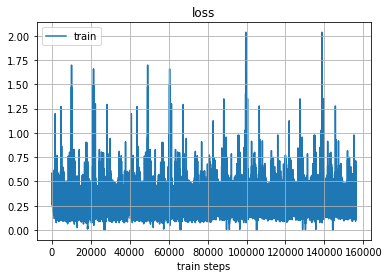

Buffered data was truncated after reaching the output size limit.

In [0]:
%%time

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, opt, 20)

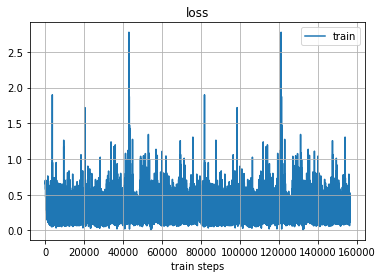

 60%|█████▉    | 46620/78153 [16:00<12:26, 42.22it/s]

KeyboardInterrupt: ignored

In [0]:
%%time

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, opt, 20)

In [0]:
model.eval()
model.forward()

In [0]:
convert_for_model(objects_from_code[:1])[0].tolist()[0]

[38, 10, 16, 46, 50, 26, 86, 89, 70, 46, 47, 9, 38, 10, 16, 46, 50, 26, 86, 46]

In [0]:
list(map(id2tok.get, convert_for_model(objects_from_code[:1])[0].tolist()[0]))

['i',
 'm',
 'p',
 'o',
 'r',
 't',
 ' ',
 'j',
 's',
 'o',
 'n',
 '\n',
 'i',
 'm',
 'p',
 'o',
 'r',
 't',
 ' ',
 'o']

In [0]:
limit = len(X_train) // batch_size * batch_size
train_data = X_train[:limit]
len(np.split(train_data, len(train_data) // batch_size))

78153

In [0]:
200. // 64 * 64 

192.0

In [0]:
l = nn.BCELoss()
tensor1 = torch.Tensor([0, 1, 0])
tensor2 = torch.Tensor([False, True, False])
l(tensor1, tensor2)

tensor(0.)

In [0]:
torch.Tensor([False, True, False])

tensor([0., 1., 0.])

In [0]:

params = {
    'batch_size': 128,
    'emb_size': 150,
    'vocab_size': len(word_to_id),
    # 'seq_len': 100,
}


In [0]:
# def get_code_data(path):
#     for _, _, files in os.walk(path):
#         data = np.empty((0, 100))
#         for file in tqdm_notebook(files):
#             with open(path + file, 'rb') as f:
#                 array = pickle.load(f)
#                 for i in tqdm_notebook(range(len(array)), leave=False):
#                     data = np.concatenate((data, array[i].inputs), axis=0)
#     return data


In [0]:
# data = get_code_data(base_path + '/after_preprocess/')

In [0]:
# with open('./after_preprocess/all_inputs', 'wb') as f:
#     pickle.dump(data.astype('int64'), f)

In [0]:
# with open(data_path, 'rb') as f:
#     bla = pickle.load(f)
# len(bla)

In [0]:
data_path = base_path + '/after_preprocess/all_inputs'

In [0]:
# split threshold for train/test
# approximately data contains 700k object
split_num = int(700000 * 0.7)

In [0]:
class CodeDataset(Dataset):
    def __init__(self, path, params, start, end):
        with open(path, 'rb') as f:
            self.data = pickle.load(f)[start:end]

    def __len__(self):
#         return 10
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index]


In [0]:
train_loader = DataLoader(
    CodeDataset(data_path, params, 0, split_num),
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=10
)

In [0]:
test_loader = DataLoader(
    CodeDataset(data_path, params, split_num, None),
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=10
)

# Инициализация модели

In [0]:
class LstmBaseline(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.embedding = nn.Embedding(
            self.params['vocab_size'],
            self.params['emb_size']
        )
        self.lstm = nn.LSTM(
            self.params['emb_size'],
            self.params['emb_size'],
#             2
            1
        )
        self.linear = nn.Linear(
            self.params['emb_size'],
            self.params['vocab_size']
        )
    
    def init_hidden(self, batch_size):
        pass

    def forward(self, inputs, hidden):
        embs = self.embedding(inputs)
        # need 100, 64, 150(?)
        # real 64, 100, 150
        output, hidden = self.lstm.forward(embs, hidden)
        output = self.linear(output)
        return output, hidden


# Обучение

In [0]:
def train_epoch(model, optimizer, lr):
    loss_log = []
    model.train()
    total = 0
    correct = 0
    
    for batch_num, x in zip(trange(len(train_loader)), train_loader):
        optimizer.zero_grad()
        x = x.to(device)
        loss_value = 0.
        loss = nn.CrossEntropyLoss()
        # todo check
        hidden = None
        for i in range(x.shape[1] - 1):
            output, hidden = model.forward(x[:, i].unsqueeze(1), hidden)
            loss_value += loss(output.squeeze(1), x[:, i + 1])
            
            _, arg_pred = torch.max(output.squeeze(1), 1)
            eq_arr = arg_pred == x[:, i + 1]
            total += eq_arr.shape[0]
            correct += int(eq_arr.sum())
        loss_value.backward()

#         torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
#         for p in model.parameters():
#             p.data.add_(-lr, p.grad.data)
        optimizer.step()
        loss_value = loss_value.item()
        loss_log.append(loss_value)# / x.shape[1])

    accuracy = correct / total
    return accuracy, loss_log

def test(model):
    loss_log = []
    model.eval()
    total = 0
    correct = 0
    for batch_num, x in zip(trange(len(test_loader)), test_loader):
        x = x.to(device)
        loss_value = 0.
        hidden = None
        for i in range(x.shape[1] - 1):
            output, hidden = model.forward(x[:, i].unsqueeze(1), hidden)
            _, arg_pred = torch.max(output.squeeze(1), 1)
            eq_arr = arg_pred == x[:, i + 1]
            total += eq_arr.shape[0]
            correct += int(eq_arr.sum())
    accuracy = correct / total
    return accuracy

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    acc_log = []
    lr = 0.05
    lr_decay_base = 1 / 1.15
    m_flat_lr = 20.0
    for epoch in range(n_epochs):
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
        accuracy, train_loss = train_epoch(model, opt, lr)
        train_log.extend(train_loss)
        acc_log.append(accuracy)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': train_log[-1]
            },
            base_path + '/model_checkpoints2/lstm_baseline_checkpoint_{}.pt'.format(epoch)
        )
        clear_output()
        print("Epoch:{}".format(epoch))
        print("Accuracy:", accuracy)
        tp.send_text('Epoch {}, LSTM baseline accuracy: {}'.format(epoch, accuracy))
        plot_history(train_log)
#     np.save("/home/.../model_checkpoints..._logs.npy", np.array(train_log))
#     np.save("/home/.../model_checkpoints..._logs_perp.npy", np.array(perp_log))


In [0]:
model = LstmBaseline(params).to(device)

Epoch:1
Accuracy: 0.35851835690202705


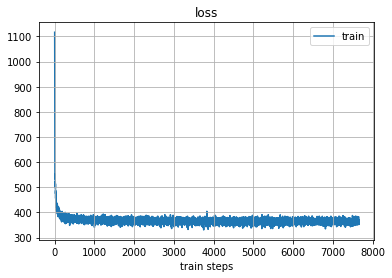

  7%|▋         | 254/3829 [05:57<1:23:40,  1.40s/it]

KeyboardInterrupt: ignored

In [0]:
%%time

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model, optimizer, 5)

In [0]:
%%time

print('Accuracy:', test(model))

100%|██████████| 1607/1607 [16:32<00:00,  1.65it/s]
Accuracy: 0.3440257559846452
CPU times: user 11min 24s, sys: 5min 3s, total: 16min 27s
Wall time: 16min 32s
